# Project 2 - Classification
## Predict customers likely to respond to a marketing campaign

### MODEL : Random Forest
#### This notebook has the Random Forest model
- We used the excel 'transformed_data2.xlsx'



# **Group W**
- Ana Rita Mateus - 20241483;
- Gabriel Fábrega - 20241530;
- Gift Kimbini Musharwa - 20241190;
- Marta Filipe - 20240211;
- Wilson Lima - 20241183.

# 1. Initializations and data loading

In [1]:

!pip install category_encoders

import os
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
import collections
from sklearn.model_selection import train_test_split
from sklearn import metrics
from yellowbrick.classifier import ROCAUC
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE


Defaulting to user installation because normal site-packages is not writeable
  Using cached scikit_learn-1.5.2-cp312-cp312-win_amd64.whl.metadata (13 kB)
Using cached scikit_learn-1.5.2-cp312-cp312-win_amd64.whl (11.0 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1


  You can safely remove it manually.


In [3]:
# Load data 
ds = pd.read_excel('transformed_data2.xlsx', sheet_name='Sheet1')
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Education                2240 non-null   object 
 1   Marital_Status           2240 non-null   object 
 2   Income                   2240 non-null   float64
 3   Recency                  2240 non-null   int64  
 4   Purchases_With_Discount  2240 non-null   float64
 5   Visits_Web_LastMonth     2240 non-null   float64
 6   Has_Complained           2240 non-null   int64  
 7   Response                 2240 non-null   int64  
 8   Age                      2240 non-null   int64  
 9   Year                     2240 non-null   int64  
 10  Month                    2240 non-null   int64  
 11  TotalSpent               2240 non-null   float64
 12  TotalAcceptedCampaigns   2240 non-null   int64  
 13  TotalPurchases           2240 non-null   float64
 14  TotalDependents         

# 2. Data Exploration

In [4]:
# Display top 10 rows
ds.head(10)

,Education,Marital_Status,Income,Recency,Purchases_With_Discount,Visits_Web_LastMonth,Has_Complained,Response,Age,Year,Month,TotalSpent,TotalAcceptedCampaigns,TotalPurchases,TotalDependents
0,Graduation,Single,58138.0,58,0.477121,0.845098,0,1,57,2012,9,12.664460,0,1.060892,0
1,Graduation,Single,46344.0,38,0.301030,0.698970,0,0,60,2014,3,2.120574,0,0.114287,2
2,Graduation,Together,71613.0,26,0.000000,0.602060,0,0,49,2013,8,10.091982,0,0.591409,0
3,Graduation,Together,26646.0,26,0.301030,0.778151,0,0,30,2014,2,4.421604,0,-0.044269,1
4,PhD,Married,58293.0,94,0.698970,0.698970,0,0,33,2014,1,9.514639,0,0.650999,1
5,Master,Together,62513.0,16,0.301030,0.778151,0,0,47,2013,9,8.555788,0,0.761789,1
6,Graduation,Divorced,55635.0,34,0.602060,0.778151,0,0,43,2012,11,10.265112,0,0.671191,1
7,PhD,Married,33454.0,32,0.301030,0.903090,0,0,29,2013,5,5.106123,0,0.080670,1
8,PhD,Together,30351.0,19,0.000000,0.954243,0,1,40,2013,6,3.480582,0,-0.108936,1
9,PhD,Together,5648.0,68,0.000000,1.301030,0,0,64,2014,3,2.225309,1,0.000000,2


In [5]:
# Summary statistics for all variables
ds.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Education,2240,5,Graduation,1127,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Marital_Status,2240,6,Married,864,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Income,2240.0,NaN,NaN,NaN,51944.873599,21490.712077,1730.0,35233.5,51277.0,68413.25,162397.0
Recency,2240.0,NaN,NaN,NaN,49.109375,28.962453,0.0,24.0,49.0,74.0,99.0
Purchases_With_Discount,2240.0,NaN,NaN,NaN,0.267168,0.283446,0.0,0.0,0.30103,0.477121,1.176091
Visits_Web_LastMonth,2240.0,NaN,NaN,NaN,0.663004,0.262617,0.0,0.477121,0.778151,0.845098,1.30103
Has_Complained,2240.0,NaN,NaN,NaN,0.009375,0.096391,0.0,0.0,0.0,0.0,1.0
Response,2240.0,NaN,NaN,NaN,0.149107,0.356274,0.0,0.0,0.0,0.0,1.0
Age,2240.0,NaN,NaN,NaN,45.096875,11.694144,18.0,37.0,44.0,55.0,74.0
Year,2240.0,NaN,NaN,NaN,2013.028125,0.684554,2012.0,2013.0,2013.0,2013.0,2014.0


# 3. Data Preparation

## 3.1 Transform variable

We transformed the **Education** variable into a numerical format to avoid the curse of dimensionality.

In [6]:
ds['Education'].unique()

array(['Graduation', 'PhD', 'Master', 'Basic', '2n Cycle'], dtype=object)

In [7]:
education_years_map = {
    'Basic': 6,
    '2n Cycle': 9,
    'Graduation': 16,
    'Master': 18,
    'PhD': 21
}

ds['Education_Years'] = ds['Education'].map(education_years_map)

In [8]:
ds.drop(columns=['Education', 'Year', 'Month', 'TotalSpent'], inplace=True)

In [9]:
X = ds

In [10]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Marital_Status           2240 non-null   object 
 1   Income                   2240 non-null   float64
 2   Recency                  2240 non-null   int64  
 3   Purchases_With_Discount  2240 non-null   float64
 4   Visits_Web_LastMonth     2240 non-null   float64
 5   Has_Complained           2240 non-null   int64  
 6   Response                 2240 non-null   int64  
 7   Age                      2240 non-null   int64  
 8   TotalAcceptedCampaigns   2240 non-null   int64  
 9   TotalPurchases           2240 non-null   float64
 10  TotalDependents          2240 non-null   int64  
 11  Education_Years          2240 non-null   int64  
dtypes: float64(4), int64(7), object(1)
memory usage: 210.1+ KB


## 3.2 Random Forest: One hot encoding

One-hot encoding is applied before modeling to convert categorical variables into a numerical format that machine learning algorithms can understand. It avoids incorrect assumptions about category order (as in label encoding) by creating separate binary columns for each category, ensuring the model interprets them correctly. 

In [11]:
# Encode boolean features into dummy variables
cols = ['Has_Complained']
X = pd.get_dummies(data=X,columns=cols,drop_first=True)

In [12]:
# Encode categorical variables to dummy variables
cols = ['Marital_Status']
ce_one_hot = ce.OneHotEncoder(cols = cols, use_cat_names=True)
X = ce_one_hot.fit_transform(X)

In [13]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Marital_Status_Single    2240 non-null   int64  
 1   Marital_Status_Together  2240 non-null   int64  
 2   Marital_Status_Married   2240 non-null   int64  
 3   Marital_Status_Divorced  2240 non-null   int64  
 4   Marital_Status_Widow     2240 non-null   int64  
 5   Marital_Status_Other     2240 non-null   int64  
 6   Income                   2240 non-null   float64
 7   Recency                  2240 non-null   int64  
 8   Purchases_With_Discount  2240 non-null   float64
 9   Visits_Web_LastMonth     2240 non-null   float64
 10  Response                 2240 non-null   int64  
 11  Age                      2240 non-null   int64  
 12  TotalAcceptedCampaigns   2240 non-null   int64  
 13  TotalPurchases           2240 non-null   float64
 14  TotalDependents         

In [14]:
# Select only numeric columns
numeric_df = ds.select_dtypes(include=['int64', 'float64'])

# Calculate the correlation matrix
corr_matrix = numeric_df.corr()

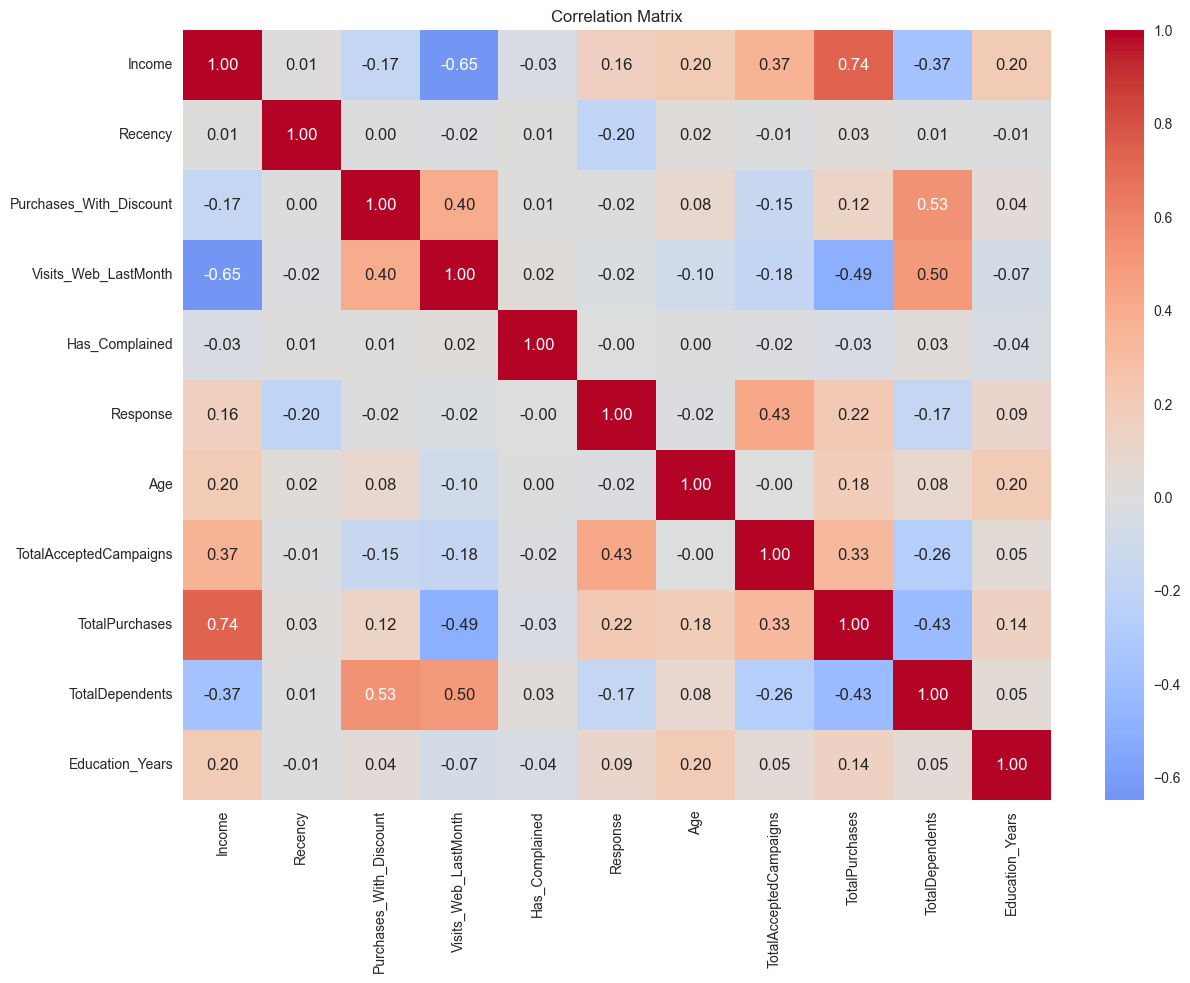

In [15]:
# Plot the heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title("Correlation Matrix")
plt.show()

In [16]:
correlation_with_response = numeric_df.corr()['Response'].sort_values(ascending=False)
print(correlation_with_response)

Response                   1.000000
TotalAcceptedCampaigns     0.426035
TotalPurchases             0.219146
Income                     0.162433
Education_Years            0.093306
Has_Complained            -0.001707
Purchases_With_Discount   -0.016932
Age                       -0.018369
Visits_Web_LastMonth      -0.023865
TotalDependents           -0.171631
Recency                   -0.198437
Name: Response, dtype: float64


# 4. Modeling - Random Forest

In this notebook we applied **Random Forest**.
<p> This model is a great choice for predictive modeling because it combines simplicity with high accuracy, making it robust to overfitting and effective for both classification problems. It operates as an ensemble of decision trees, each trained on different subsets of the data and features, which improves generalization to unseen data. 
<p> Additionally, it is relatively insensitive to outliers and variable scaling, requires minimal preprocessing, and handles encoded categorical variables well. Moreover, it provides feature importance metrics, offering insights into which variables have the most influence on the predictions.

In [17]:
# Create the Target
y = X['Response']

In [18]:
# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=123)

In [19]:
# Remove the Target from the training
X_train = X_train.drop(['Response'],axis=1)
X_test = X_test.drop(['Response'],axis=1)

Counter({0: 1429, 1: 251})
Response
0    0.850595
1    0.149405
Name: proportion, dtype: float64


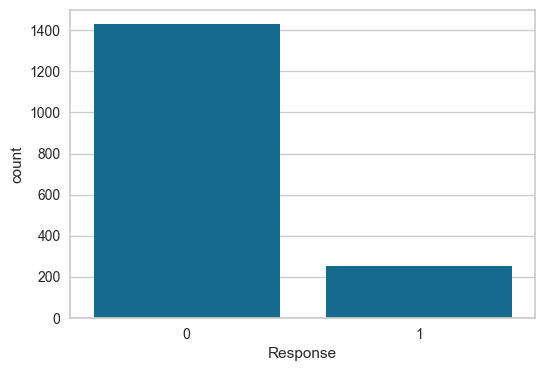

In [20]:
# Display target balance in the training dataset
print(collections.Counter(y_train))
fig, ax = plt.subplots(figsize=(6,4))
sns.countplot(x="Response", data=pd.DataFrame(data={'Response':y_train}), ax=ax)
print(y_train.value_counts(normalize=True))

In [21]:
# Create object and train the model
classModel = RandomForestClassifier(random_state=123, n_jobs=-1, class_weight='balanced', max_depth=4, min_samples_leaf = 2, n_estimators=100)
classModel.fit(X_train.values, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=4, min_samples_leaf=2,
                       n_jobs=-1, random_state=123)

In [22]:
pipeline = Pipeline([
    ('smote', SMOTE(sampling_strategy=1, random_state=123)),
    ('feature_selection', RFE(estimator=RandomForestClassifier())),
    ('classifier', RandomForestClassifier(random_state=123))
])

In [23]:
param_grid = {
    # Feature Selection
    'feature_selection__n_features_to_select': [6, 8, 10, 12, 14, 16],  

    # Random Forest Hyperparameters
    'classifier__n_estimators': [20, 30, 40, 50, 60, 80, 100],   # Small to moderate ensemble sizes
    'classifier__max_depth': [2, 3],                   # Keep trees shallow
    'classifier__min_samples_split': [2,3],              # Prevent too many splits
    'classifier__min_samples_leaf': [2],               # Enforce large leaf nodes
    'classifier__max_features': ['sqrt'],          # Smaller subset = less overfit
    'classifier__bootstrap': [True],                         # Keep randomness
    'classifier__class_weight': ['balanced']                 # Useful for imbalance
}

Setting parameters in a Random Forest model is essential to control its learning behavior, prevent overfitting, and improve generalization. Key hyperparameters like the number of trees (n_estimators), tree depth (max_depth), and minimum samples per split or leaf help balance model complexity and performance. For example, limiting tree depth can reduce overfitting, while using a suitable number of features at each split (max_features) promotes diversity among trees, enhancing overall accuracy. Proper tuning of these parameters—often done using methods like Grid Search—ensures the model performs well on both training and unseen data.

In [24]:
# Define stratified k-fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

In [25]:
# Setup RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    n_iter=20,               
    cv=cv,
    scoring='f1',
    n_jobs=-1,
    verbose=2,
    random_state=123
)

In [26]:
# Fit the randomized search
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=123, shuffle=True),
                   estimator=Pipeline(steps=[('smote',
                                              SMOTE(random_state=123,
                                                    sampling_strategy=1)),
                                             ('feature_selection',
                                              RFE(estimator=RandomForestClassifier())),
                                             ('classifier',
                                              RandomForestClassifier(random_state=123))]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'classifier__bootstrap': [True],
                                        'classifier__class_weight': ['balanced'],
                                        'classifier__max_depth': [2, 3],
                                        'classifier__max_features': ['sqrt'],
                                        'classifier__min_samples_leaf': [2],
                                        'classifier__min_samples_split': [2, 3],
                                        'classifier__n_estimators': [20, 30, 40,
                                                                     50, 60, 80,
                                                                     100],
                                        'feature_selection__n_features_to_select': [6,
                                                                                    8,
                                                                                    10,
                                                                                    12,
                                                                                    14,
                                                                                    16]},
                   random_state=123, scoring='f1', verbose=2)

In [27]:
# Best model and performance
print("Best params:", random_search.best_params_)
print("Best Precision score:", random_search.best_score_)

Best params: {'feature_selection__n_features_to_select': 14, 'classifier__n_estimators': 60, 'classifier__min_samples_split': 3, 'classifier__min_samples_leaf': 2, 'classifier__max_features': 'sqrt', 'classifier__max_depth': 3, 'classifier__class_weight': 'balanced', 'classifier__bootstrap': True}
Best Precision score: 0.5050080720176998


Here we can see the best parameters to aplly in this specific model.

In [28]:
# You can now use the best estimator to make predictions
best_rf = random_search.best_estimator_
y_pred = best_rf.predict(X_test.values)

C:\Users\wilso\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RFE was fitted with feature names
  warnings.warn(


# 5. Interpretation

In [29]:
# Fit the search object
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=123, shuffle=True),
                   estimator=Pipeline(steps=[('smote',
                                              SMOTE(random_state=123,
                                                    sampling_strategy=1)),
                                             ('feature_selection',
                                              RFE(estimator=RandomForestClassifier())),
                                             ('classifier',
                                              RandomForestClassifier(random_state=123))]),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'classifier__bootstrap': [True],
                                        'classifier__class_weight': ['balanced'],
                                        'classifier__max_depth': [2, 3],
                                        'classifier__max_features': ['sqrt'],
                                        'classifier__min_samples_leaf': [2],
                                        'classifier__min_samples_split': [2, 3],
                                        'classifier__n_estimators': [20, 30, 40,
                                                                     50, 60, 80,
                                                                     100],
                                        'feature_selection__n_features_to_select': [6,
                                                                                    8,
                                                                                    10,
                                                                                    12,
                                                                                    14,
                                                                                    16]},
                   random_state=123, scoring='f1', verbose=2)

Observations and Justifications:

- A **randomized search** is used to efficiently explore a wide range of hyperparameter combinations. Unlike grid search, which tests all possible combinations, randomized search samples a fixed number of parameter settings, offering a good trade-off between performance and computational cost.

- The pipeline is composed of the following components, each serving a specific purpose:
    - **SMOTE** (Synthetic Minority Over-sampling Technique): Addresses class imbalance by synthetically generating new examples of the minority class. This helps prevent the model from becoming biased toward the majority class and improves its ability to detect minority class instances.

    - **RFE** (Recursive Feature Elimination): Reduces dimensionality by iteratively removing the least important features based on model performance. This helps eliminate noise, reduces overfitting, and improves both model interpretability and efficiency.
    
    - **RandomForestClassifier**: Serves as the core predictive model. It's robust to overfitting, handles both linear and non-linear relationships well, and provides feature importance metrics, which are useful for feature selection (as used in RFE). Its performance is further enhanced by tuning its hyperparameters through randomized search.



In [30]:
# Get the best estimator's pipeline
best_pipeline = random_search.best_estimator_

In [31]:
# Extract the trained Random Forest model
rf_model = best_pipeline.named_steps['classifier']

In [32]:
# Get feature names (after selection, if used)
selector = best_pipeline.named_steps.get('feature_selection')
if selector:
    selected_features = X_train.columns[selector.get_support()]
else:
    selected_features = X_train.columns


Checks if feature selection (RFE) was applied.

- If yes, gets the names of the features selected during the process.
- If no, keeps all original columns.

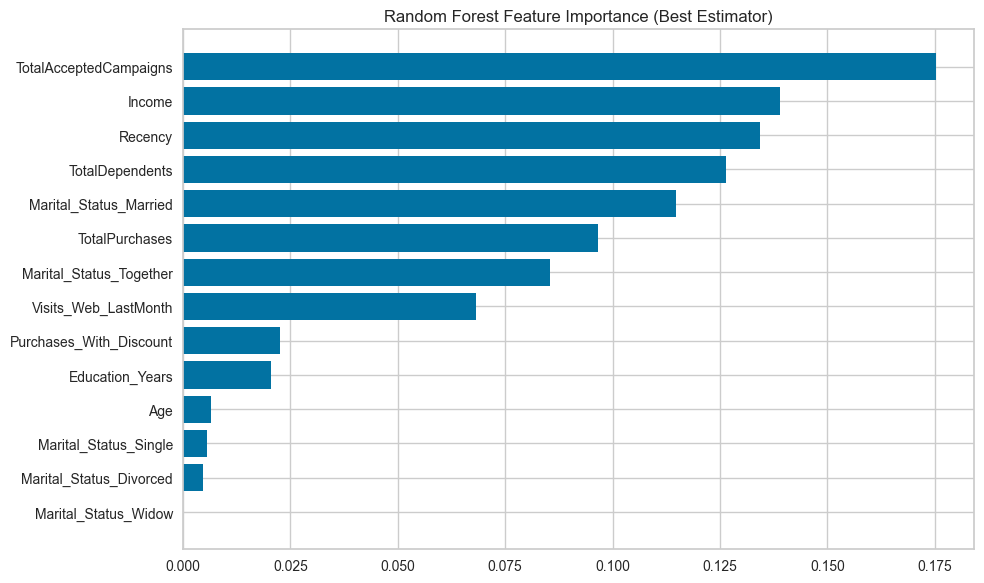

In [33]:
# Get and plot feature importance
importances = rf_model.feature_importances_
importance_df = pd.DataFrame({'Feature': selected_features, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.gca().invert_yaxis()
plt.title('Random Forest Feature Importance (Best Estimator)')
plt.tight_layout()
plt.show()


Observations: 

The feature importance analysis from the Random Forest model shows that behavioral and transactional features like **TotalAcceptedCampaigns**, **Income**, and **Recency** are the most influential in predicting outcomes, indicating that customer engagement and spending power play key roles in the model's decisions. 
<p> In contrast, demographic features like Age, Education_Years, and certain marital status categories contribute minimally, indicating limited predictive value.

# 6. Evaluation A

Evaluating the model after it has been applied is essential to ensure its effectiveness, identify potential issues such as overfitting or bias, and confirm that it generalizes well to new and unseen data.

In [34]:
# predict y for X_train and X_test
y_pred_train = best_rf.predict(X_train.values) 
y_pred_test = best_rf.predict(X_test.values) 

C:\Users\wilso\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RFE was fitted with feature names
  warnings.warn(
C:\Users\wilso\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RFE was fitted with feature names
  warnings.warn(


In [35]:
# Function to create dataframe with metrics
def performanceMetricsDF(metricsObj, yTrain, yPredTrain, yTest, yPredTest):
  measures_list = ['ACCURACY','PRECISION', 'RECALL','F1 SCORE','AUC']
  train_results = [metricsObj.accuracy_score(yTrain, yPredTrain),
                metricsObj.precision_score(yTrain, yPredTrain),
                metricsObj.recall_score(yTrain, yPredTrain),
                metricsObj.f1_score(yTrain, yPredTrain),
                metricsObj.roc_auc_score(yTrain, yPredTrain)
                ]
  test_results = [metricsObj.accuracy_score(yTest, yPredTest),
               metricsObj.precision_score(yTest, yPredTest),
               metricsObj.recall_score(yTest, yPredTest),
               metricsObj.f1_score(yTest, yPredTest),
               metricsObj.roc_auc_score(yTest, yPredTest)
               ]
  resultsDF = pd.DataFrame({'Measure': measures_list, 'Train': train_results, 'Test':test_results})
  return(resultsDF)

In [36]:
# Function to plot confusion matrix - Adapted from https://github.com/DTrimarchi10/confusion_matrix/blob/master/cf_matrix.py
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    ax = sns.heatmap(cf,annot=box_labels, fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

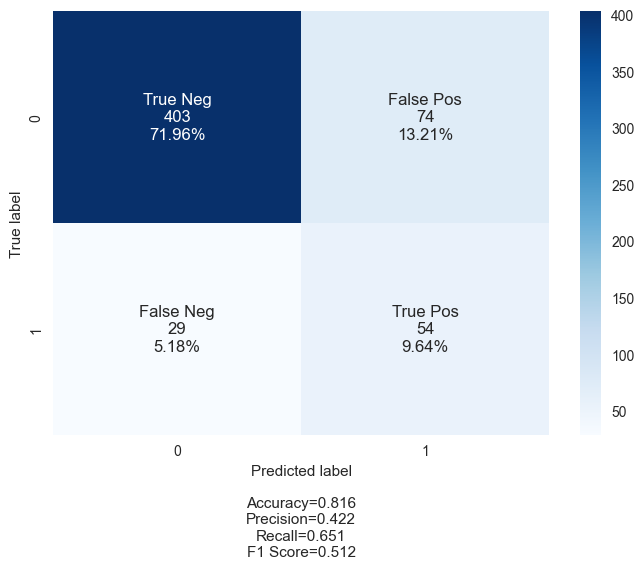

In [37]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_pred_test)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['0', '1']
make_confusion_matrix(cf, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

Observations: 

The confusion matrix compares the model’s predictions with the true values, showing:
- True Negatives (403 - 71.96%): Cases correctly predicted as not responding to the campaign (class 0). This corresponds to €1209 in predicted contact costs (403 clients * €3 per contact) and a real loss of €4433 (403 clients * €11 per response) in profit.
- False Positives (74 - 13.21%): Cases predicted as responding to the campaign (class 1), but actually did not respond (class 0). This represents €222 (74 clients * €3 per contact) in predicted contact costs for clients incorrectly predicted to respond. Additionally, we are overestimating €814 (74 clients * €11 per response)in profit that won’t actually materialize.
- False Negatives (29 - 5.18%): Cases predicted as not responding (class 0), but who actually responded to the campaign (class 1). This results in €319 (29 clients * €11 per response) less profit than expected.
- True Positives (54 - 9.64%): Cases correctly predicted as responding to the campaign (class 1). This corresponds to a real contact cost of €162 (54 clients * €3 per contact) and a real profit of €594 (54 clients * €11 per response).

Model evaluation metrics:
- Accuracy (0.816): The model correctly predicted 81.6% of all samples.
- Precision (0.422): Of all cases predicted as responders (class 1), only 42.2% actually responded, indicating many false positives.
- Recall (0.651): The model correctly identified 65.1% of the actual responders.
- F1 Score (0.512): a moderate value reflecting the limited balance between precision and recall in identifying responders.

Conclusion:
The model shows good overall accuracy but has difficulty correctly predicting responders (class 1), producing many false positives and a relatively low F1 score. Recall is somewhat better, but there is room to improve the identification of all campaign responders.

In [38]:
resultsDF = performanceMetricsDF(metrics, y_train, y_pred_train, y_test, y_pred_test)
resultsDF

,Measure,Train,Test
0,ACCURACY,0.829167,0.816071
1,PRECISION,0.452128,0.421875
2,RECALL,0.677291,0.650602
3,F1 SCORE,0.542265,0.511848
4,AUC,0.766567,0.747733


**Metrics Interpretation**
- Accuracy
    - Train: 0.829 (82.9%)
    - Test: 0.816 (81.6%) Accuracy is slightly lower on the test set, but the difference is minimal, indicating consistent performance and acceptable generalization.

- Precision
    - Train: 0.452 (45.2%)
    - Test: 0.422 (42.2%) Precision is relatively low, indicating that many predicted positives are false positives. It’s slightly lower on the test set, which suggests a small drop in prediction reliability.

- Recall (Sensitivity)
    - Train: 0.677 (67.7%)
    - Test: 0.651 (65.1%) Recall is moderately high, meaning the model captures most of the actual positives, with small variation between training and test sets.

- F1 Score
    - Train: 0.542 (54.2%)
    - Test: 0.512 (51.2%) The F1 score reflects moderate performance, with a slight decrease in the test set. This indicates a trade-off between precision and recall.

- AUC (Area Under the ROC Curve)  
    - Train: 0.767 (76.7%)
    - Test: 0.748 (74.8%) AUC values show decent discrimination ability, with a small drop from train to test — consistent with overall generalization.

**Overall Analysis**
The model demonstrates stable performance across training and test sets. While precision is relatively low, the model maintains a good recall, suggesting it is effective at identifying positives but may benefit from further refinement to reduce false positives. The close alignment of training and test metrics indicates no strong signs of overfitting, with reasonable generalization.

**Conclusion**
This model performs moderately well for the classification task. While it captures positives reliably (good recall), the lower precision highlights an opportunity to improve the accuracy of positive predictions. Overall, the model shows balanced behavior with fair generalization and room for optimization.

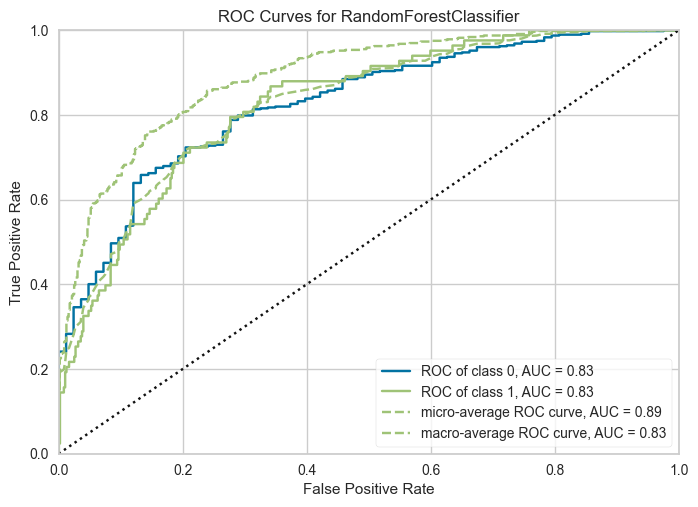

<Axes: title={'center': 'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [39]:
# ROC curve
visualizer = ROCAUC(classModel, classes=['0','1'])
visualizer.fit(X_train.values, y_train)
visualizer.score(X_test.values, y_test)
visualizer.show()

Results Obtained with the RandomForestClassifier: 

- **Class 0 and Class 1**: AUC of 0.83 for both, indicating the model effectively distinguishes responders from non-responders to the campaigns.
- **Micro-average AUC**: 0.89, aggregating all cases and showing very good overall performance, especially for more frequent classes.
- **Macro-average AUC**: 0.83, representing the average across classes and indicating balanced treatment of each class.

All ROC curves are well above the random baseline, demonstrating strong discriminative power.


**Implications for Our Problem**
<p> The goal is to predict which customers will respond to a marketing campaign, allowing the marketing team to focus resources on those with higher conversion potential.
<p> High AUC values indicate the model reliably differentiates likely responders from non-responders across different thresholds.
This enables more accurate decisions, better budget allocation, and increased return on investment (ROI) for campaigns.
Balanced performance across classes ensures no group is disproportionately favored, reducing wasted resources and missed opportunities.


**Conclusion**
The RandomForestClassifier shows strong predictive performance with AUCs above 0.83 in all cases, making it an effective tool for helping the marketing department identify potential responders and enhance campaign efficiency.

# 7. Tuning with treshold adjusting 

In [40]:
thresholds = np.arange(0.0, 1.01, 0.01)

In [41]:
# Get predicted probabilities from your trained pipeline
y_proba = best_rf.predict_proba(X_test)[:, 1]  # Get the probability of the positive class

In [42]:
profits = []
for t in thresholds:
    y_pred = (y_proba >= t).astype(int)
    TP = np.sum((y_test == 1) & (y_pred == 1))
    FP = np.sum((y_test == 0) & (y_pred == 1))
    
    revenue = 11 * TP
    cost = 3 * (TP + FP)
    net_profit = revenue - cost
    profits.append(net_profit)

# Find threshold with max profit
best_threshold = thresholds[np.argmax(profits)]
max_profit = np.max(profits)

print(f"Best threshold for max profit: {best_threshold:.3f} (Profit: {max_profit}€)")

Best threshold for max profit: 0.520 (Profit: 221€)


In [43]:
# Apply your custom threshold
custom_threshold = 0.520  
y_pred_custom = (y_proba >= custom_threshold).astype(int)

C:\Users\wilso\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


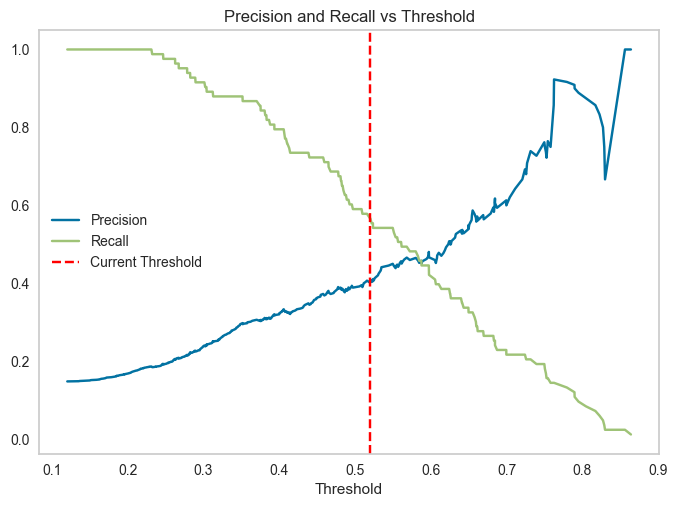

In [44]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

y_scores = classModel.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.axvline(0.52, color='red', linestyle='--', label='Current Threshold')
plt.xlabel('Threshold')
plt.legend()
plt.title('Precision and Recall vs Threshold')
plt.grid()
plt.show()

The Precision-Recall vs. Threshold curve is a vital tool for understanding the behavior of a binary classifier and for selecting a classification threshold that best suits the specific needs and priorities of the problem by visualizing the trade-off between precision and recall across different decision points.
<p>There is an inherent trade-off between precision and recall, which vary inversely as the classification threshold changes.
<p> The best threshold is context-dependent and guided by the practical impact of classification errors.
<p> Here we can visualize the two diferences of precison and recall with diferents thresolds. The red line represnts the result of the best threshold when we have a balanced 



# 8. Evaluation B

In [45]:
# predict y for X_train and X_test
y_pred_train = best_rf.predict(X_train) 
y_pred_test = best_rf.predict(X_test) 

In [46]:
# Function to create dataframe with metrics
def performanceMetricsDF(metricsObj, yTrain, yPredTrain, yTest, y_pred_custom):
  measures_list = ['ACCURACY','PRECISION', 'RECALL','F1 SCORE','AUC']
  train_results = [metricsObj.accuracy_score(yTrain, yPredTrain),
                metricsObj.precision_score(yTrain, yPredTrain),
                metricsObj.recall_score(yTrain, yPredTrain),
                metricsObj.f1_score(yTrain, yPredTrain),
                metricsObj.roc_auc_score(yTrain, yPredTrain)
                ]
  test_results = [metricsObj.accuracy_score(yTest, y_pred_custom),
               metricsObj.precision_score(yTest, y_pred_custom),
               metricsObj.recall_score(yTest, y_pred_custom),
               metricsObj.f1_score(yTest, y_pred_custom),
               metricsObj.roc_auc_score(yTest, y_pred_custom)
               ]
  resultsDF = pd.DataFrame({'Measure': measures_list, 'Train': train_results, 'Test':test_results})
  return(resultsDF)

In [47]:
# Function to plot confusion matrix - Adapted from https://github.com/DTrimarchi10/confusion_matrix/blob/master/cf_matrix.py
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    ax = sns.heatmap(cf,annot=box_labels, fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

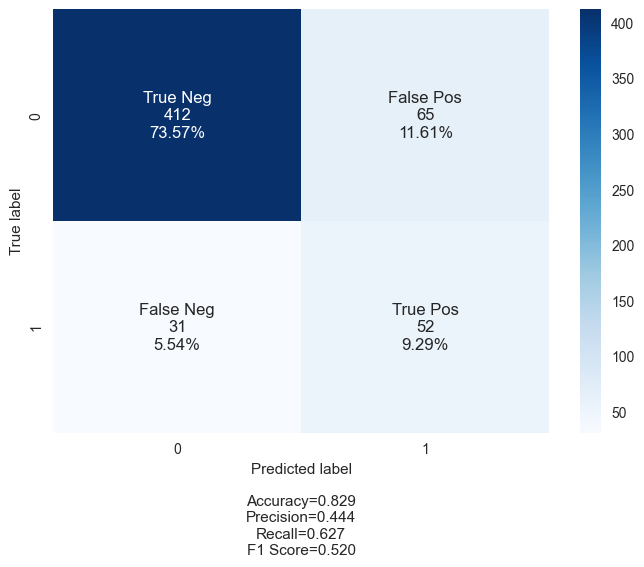

In [48]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_pred_custom)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['0', '1']
make_confusion_matrix(cf, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

Observations: 

The confusion matrix compares the model’s predictions with the true values, showing:
- True Negatives (412 - 71.96%): Cases correctly predicted as not responding to the campaign (class 0). This corresponds to €1236 in predicted contact costs (412 clients × €3 per contact) and a real loss of €4532 (412 clients * €11 per response) in profit.
- False Positives (65 - 13.21%): Cases predicted as responding to the campaign (class 1), but actually did not respond (class 0). This represents €195 (65 clients * €3 per contact) in predicted contact costs for clients incorrectly predicted to respond. Additionally, we are overestimating €715 (65 clients * €11 per response)in profit that won’t actually materialize.
- False Negatives (31 - 5.18%): Cases predicted as not responding (class 0), but who actually responded to the campaign (class 1). This results in €341 (31 clients * €11 per response) less profit than expected.
- True Positives (52 - 9.64%): Cases correctly predicted as responding to the campaign (class 1). This corresponds to a real contact cost of €156 (52 clients * €3 per contact) and a real profit of €572 (52 clients * €11 per response).

Model evaluation metrics:
- Accuracy (0.829): The model correctly predicted 82.9% of all samples.
- Precision (0.444): Of all cases predicted as responders (class 1), only 44.4% actually responded, indicating many false positives.
- Recall (0.627): The model correctly identified 62.7% of the actual responders.
- F1 Score (0.52): a moderate value reflecting the limited balance between precision and recall in identifying responders.

**Conclusion:**
The model shows good overall accuracy but has difficulty correctly predicting responders (class 1), producing many false positives and a relatively low F1 score. Recall is somewhat better, but there is room to improve the identification of all campaign responders.
<p> Compare it with the previous model, this one presents a better performance in general for our classification problem.

In [49]:
resultsDF = performanceMetricsDF(metrics, y_train, y_pred_train, y_test, y_pred_custom)
resultsDF

,Measure,Train,Test
0,ACCURACY,0.829167,0.828571
1,PRECISION,0.452128,0.444444
2,RECALL,0.677291,0.626506
3,F1 SCORE,0.542265,0.520000
4,AUC,0.766567,0.745119


**Metrics Interpretation**

- Accuracy
    - Train: 0.829 (82.9%)
    - Test: 0.829 (82.9%)
Accuracy is virtually identical between the training and test sets, indicating consistent performance and excellent generalization of the model.

-  Precision
    - Train: 0.452 (45.2%)
    - Test: 0.444 (44.4%)
Precision is relatively low in both sets, suggesting that a significant portion of the instances classified as positive are actually negative (false positives). The small drop in the test set indicates a slight decrease in the reliability of positive predictions.

- Recall (Sensitivity)
    - Train: 0.677 (67.7%)
    - Test: 0.627 (62.7%)
Recall is moderately high, meaning the model manages to identify a good proportion of the actual positive instances. There is a small decrease in the test set, indicating that the model slightly loses its ability to identify unseen positives.

- F1 Score
    - Train: 0.542 (54.2%)
    - Test: 0.520 (52.0%)
The F1 Score, which balances precision and recall, shows moderate performance with a slight reduction in the test set. This reflects the trade-off between the ability to avoid false positives and the ability to find all actual positives.

- AUC (Area Under the ROC Curve)
    - Train: 0.767 (76.7%)
    - Test: 0.745 (74.5%)
The AUC values demonstrate a reasonable ability to discriminate between the classes, with a slight drop from the training to the test set, which is consistent with the overall generalization of the model.

**Overall Analysis**
<p> The model demonstrates stable performance between the training and test sets, which is a good sign of generalization. However, the relatively low precision suggests that the model tends to classify many negative instances as positive. On the other hand, the moderate recall indicates that it still manages to identify a good portion of the true positive instances. The closeness of the metrics between training and testing does not indicate significant overfitting.

**Conclusion:**
<p> This model performs moderately well for the classification task. While it is reasonably effective at identifying positive instances (good recall), the low precision highlights the need for improvements to reduce the number of false positives. Overall, the model shows balanced behavior with fair generalization, but with room for optimization, especially regarding precision.
<p> When compared with the previous model, this one presents better results, without overfiting, in all the metrics. For our specific problem, this one is the best option of this notebook.

C:\Users\wilso\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RFE was fitted with feature names
  warnings.warn(


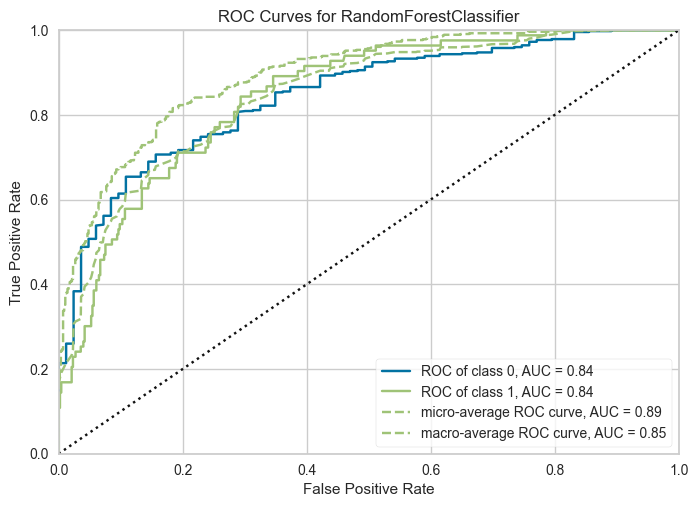

<Axes: title={'center': 'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [50]:
# ROC curve
visualizer = ROCAUC(best_rf, classes=['0','1'])
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()


Results Obtained with the RandomForestClassifier: 

- **Class 0 and Class 1**: AUC of 0.84 for both, indicating the model effectively distinguishes responders from non-responders to the campaigns.
- **Micro-average AUC**: 0.89, aggregating all cases and showing very good overall performance, especially for more frequent classes.
- **Macro-average AUC**: 0.85, representing the average across classes and indicating balanced treatment of each class.

All ROC curves are well above the random baseline, demonstrating strong discriminative power.

**Conclusion**
The RandomForestClassifier demonstrates robust predictive performance, achieving AUCs around 0.84 across all scenarios. This makes it a highly effective tool for the marketing department to more accurately identify potential responders, outperforming the previous model we presented in this notebook.